# Chess Board
In this notebook, we try to build a model of the protein at the right granularity. To do this, we need to define a fragmentation that remains pure across the different snapshots. 

In [1]:
from BigDFT import BioQM
from os.path import basename #join, 
from futile.Utils import file_list
outdir = "serialized"

In [2]:
archives={basename(f).split('.')[0].lstrip('Mpro').split('1.1')[0].replace('-XTB-1','')[1:]: f for f in file_list(outdir,'.tar.bz2',include_directory_path=True)}

In [3]:
#systems_dict = { k:{'system':systems[f],'archive':f} for k,f in archives.items()}
archives_dict = { k:{'archive':f} for k,f in archives.items()}

Read in the structures.

In [4]:
def el_df(sys):
    from BigDFT.PointParticles import electrostatic_energy_dict
    pp = sys.PointParticles
    sl = sys.dataframe_slicing()
    return pp.Eel_dict(sl)
def at_df(sys):
    return sys.df

In [5]:
population = BioQM.BioSystemPopulation(systems=archives_dict,representative='x0072',
                                       serialization_version='1.1',to_evaluate={'el':el_df},
                                       options=dict(sequence_from_fragments=True,disable_warnings=True))

KeyboardInterrupt: 

In [6]:
population.serialize(archive='diamond-moonshot.tar.gz')

In [6]:
#start from this cell in the case of a serialized population
repop = BioQM.BioSystemPopulation.load('diamond-moonshot.tar.gz',options=dict(sequence_from_fragments=True,disable_warnings=True))

0:  # weight=1.0
  - bond_orders
  - system_dfs
  - interactions


In [157]:
from BigDFT import PointParticles
from BigDFT.Stats import Population
from pandas import DataFrame as DF
reload(PointParticles)
alldf = repop.populations['system_dfs']
newpop = Population()
for i,(key, df) in enumerate(zip(alldf.sample_labels,alldf.datas)):
    print (key)
    from BigDFT.Systems import point_particle_objects, fragment_slicing_from_system_dataframe
    from BigDFT.PointParticles import PointParticles as PPs
    PP = PPs(**point_particle_objects(df))
    sl =fragment_slicing_from_system_dataframe(df)
    dfnew = DF(PP.Eel_dict(sl))
    newpop.append(dfnew)
    dfold = repop.populations['el'].datas[i]
    dfdiff= dfnew - dfold
    for col in dfnew.columns:
        assert col in dfold
    print key,np.max(np.abs(dfdiff.values))
    

x1392
x1392 0.8648891488926989
x1412
x1412 0.8410023123011794
x0705
x0705 0.8240823428073831
x1418
x1418 0.8379462490429157
x0708
x0708 0.8420625978179288
x0426
x0426 0.8436366794680952
x0425
x0425 0.8626136224399907
x0387
x0387 0.8425046531222647
x1093
x1093 0.7824556840024393
x0305
x0305 0.8016552557287806
x1308
x1308 0.8422530226934537
x1012
x1012 0.8330102852965644
x1493
x1493 0.8672404272738632
x0540
x0540 0.8277811250027942
x0946
x0946 0.8277581576252553
x1119
x1119 0.8518424586148865
x1402
x1402 0.8176559150196958
x1351
x1351 0.8987751887062929
x0736
x0736 0.8251472031431768
x0734
x0734 0.8612568983092981
x0731
x0731 0.8265429053951223
x0434
x0434 0.762335790031095
x1086
x1086 0.8243383322025597
x1101-1
x1101-1 0.8495434361351852
x1101-0
x1101-0 0.7991294372337627
x1002
x1002 0.8534895947523569
x0336
x0336 0.8565621641398633
x0771
x0771 0.8537522225564471
x1311
x1311 0.8775100584334794
x0830
x0830 0.7953254728886865
x0831
x0831 0.7849457913282052
x1249
x1249 0.8724706151347199
x

In [158]:
def average_strenght(pops,enzyme):
    from pandas import DataFrame
    from numpy import isnan,max as M
    datadict = {}
    for label, data in zip(pops.sample_labels,pops.datas):
        fragments = list(data.columns)
        target = [f for f in fragments if f not in enzyme]
        #print (label, target, M(data.values))
        fulldata = {frag: d for frag,d in zip(fragments,BioQM.interaction_strengths(fragments,target,data)) if not isnan(d)}
        datadict[label] = fulldata
    return DataFrame(datadict).dropna(how='any')

In [122]:
pockets = {}
for res,pkt in np.loadtxt('pockets.txt',dtype=str,usecols=[0,1]):
    pockets.setdefault(pkt,[]).append(res)

In [123]:
for res in pockets.values():
    for r in res:
        assert r in repop
chains = [{'title': 'pockets', 'cats': pockets}]
chains += [{'title': str(c), 'cats':cbs[-1]} for c,cbs in sorted(repop.chessboard_dict.items(),key=lambda x:x[0], reverse=True) ]

In [160]:
df = average_strenght(newpop,repop.sequences_to_fragments[0])
import clustergrammer_widget as cw
net = cw.Network(cw.clustergrammer_widget)
net.load_df(df)
net.add_cats('row',chains)
net.cluster(enrichrgram=True)
net.widget()

Y2x1c3RlcmdyYW1tZXJfd2lkZ2V0KG5ldHdvcms9dSd7Im1hdCI6IFtbLTAuMDQ3NDQ0ODQ1MjAzNDQ5MDM1LCAtMC4wMzgxMjI4MTA3MTE5ODA4MzUsIC0wLjAzNzM0NjU1OTM4NjU3ODc5LCDigKY=


In [162]:
df = average_strenght(repop.populations['interactions'],repop.sequences_to_fragments[0])
import clustergrammer_widget as cw
net = cw.Network(cw.clustergrammer_widget)
net.load_df(df)
net.add_cats('row',chains)
net.cluster(enrichrgram=True)
net.widget()

Y2x1c3RlcmdyYW1tZXJfd2lkZ2V0KG5ldHdvcms9dSd7Im1hdCI6IFtbLTIuODE0MTA0MDkwMDQyOTIzZS0xMCwgLTAuMDAxMDQ5NzIzODg2MTM3NDkwNywgLTEuMTY4ODg4NjIyMTgzMzMyOWXigKY=


In [8]:
repop.populations['system_dfs'].full_weight

92.0

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

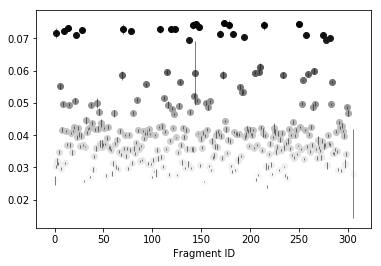

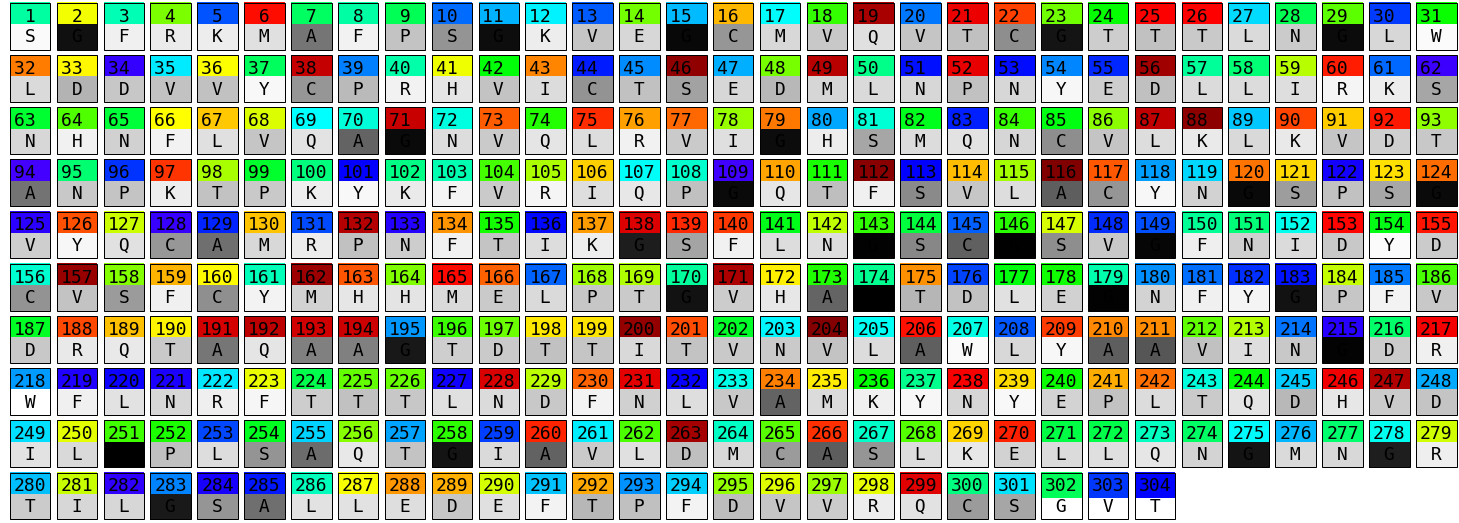

In [19]:
repop.represent(color_by='purity',with_fragment_labels=True)

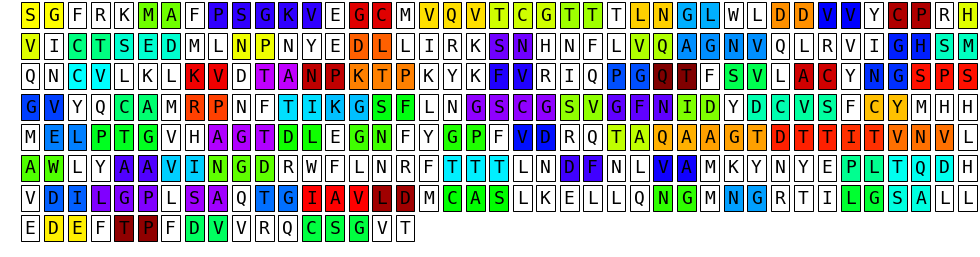

In [12]:
repop.display_sequences(view=repop.refragment(0.04))

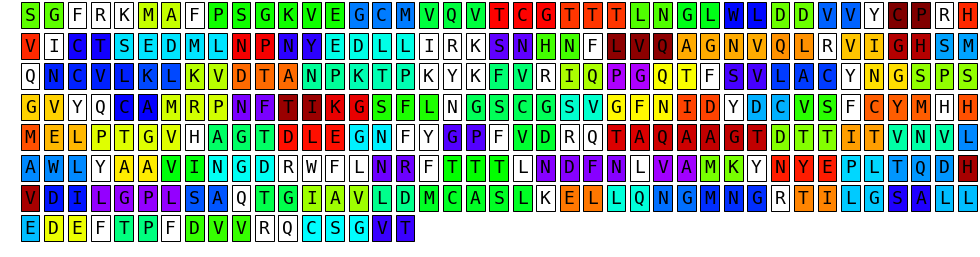

In [13]:
repop.display_sequences(view=repop.refragment(0.035))

In [23]:
chessboards = {c: None for c in [0.05,0.045,0.04,0.035,0.03,0.025]}
def clean_view(view_orig,system):
    if view_orig is None:
        return None
    view = view_orig.copy()
    allvals = []
    for k,val_orig in view_orig.items():
        val = [v for v in val_orig]
        for v in val_orig:
            if v not in system:
                previous_k = '+'.join(val)
                view.pop(previous_k)
                val.remove(v)
                rek = '+'.join(val)
                view[rek]=val
                print 'removed',v,val
            else:
                allvals.append(v)
    for k in view.keys():
        if len(view[k]) == 0:
            view.pop(k)
    for k in system:
        if k not in allvals:
            view[k]=[k]
    return view
def update_fragmentation(cutoff,sys):
    import numpy
    global chessboards
    view = clean_view(chessboards[cutoff],sys)
    review = sys.refragment(cutoff,view=view)
    chessboards[cutoff] = review
    fragmented = []
    for frag in review:
        if '+' in frag:
            fragmented += review[frag]
    infrag = numpy.zeros(len(sys.fragment_names))
    for ifrag, frag in enumerate(sys.fragment_names):
        if frag in fragmented:
            infrag[ifrag]=1
    return infrag
def frag_cutoff(cutoff):
    from functools import partial
    return partial(update_fragmentation,cutoff)
to_evaluate = {k:frag_cutoff(k) for k in chessboards}

In [4]:
def interaction_with_inhibitor(sys):
    return sys.fragment_interaction_strengths(sys.unmatched_fragments)

In [5]:
archives_dict

{'x0705': {'archive': 'serialized/Mpro-x0705-XTB-1.1.tar.bz2'},
 'x0708': {'archive': 'serialized/Mpro-x0708-XTB-1.1.tar.bz2'},
 'x1392': {'archive': 'serialized/Mpro-x1392-XTB-1.1.tar.bz2'},
 'x1412': {'archive': 'serialized/Mpro-x1412-XTB-1.1.tar.bz2'},
 'x1418': {'archive': 'serialized/Mpro-x1418-XTB-1.1.tar.bz2'}}

In [6]:
population = BioQM.BioSystemPopulation(systems=archives_dict,representative='x0072', to_evaluate={'inhibitors': interaction_with_inhibitor},
                                       serialization_version='1.1',
                                       options=dict(sequence_from_fragments=True,disable_warnings=True))

x1392:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x1412:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0705:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x1418:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0708:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0426:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0425:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0387:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x1093:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  - charge
  - purity
x0305:  # weight=1.0
  - interactions
  - bond_orders
  - dipole
  - inhibitors
  

In [185]:
from BigDFT import PostProcessing as PP
reload(PP)

<module 'BigDFT.PostProcessing' from '/home/genovese/binaries/1.9-py2/install/lib/python2.7/site-packages/BigDFT/PostProcessing.pyc'>

In [186]:
from BigDFT.PostProcessing import systems_heatmap

In [201]:
def interaction_data(population):
    pop = population.populations['inhibitors']
    data = {}
    for i,ints in enumerate(pop.datas):
        data[pop.sample_labels[i]] = {f: ints[j] for j, f in enumerate(population.fragment_names)}
    return data

In [188]:
def nonzero_part(data,cutoff):
    nonzero = set()
    for dat in data.values():
        for f in dat:
            if abs(dat[f]) > cutoff:
                nonzero.add(f)
    return nonzero

In [189]:
order_by_cys = [[k,ints['A-CYS:145']] for  k, ints in data.items()]

In [190]:
cols = [ c[0] for c in sorted(order_by_cys,key=lambda x: x[1])] 

In [191]:
from BigDFT.IO import reorder_fragments

In [192]:
inds = reorder_fragments(list(nonzero_part(data,1.5e-2)))

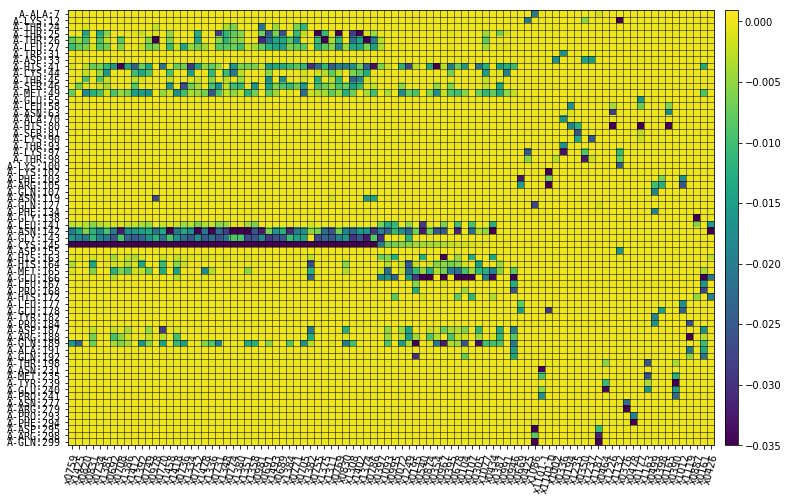

In [206]:
im = systems_heatmap(data,restrict_to=[inds],columns=cols,vmin=-0.035)

In [167]:
repop.display(cartoon=True,color_by='charge')

KeyboardInterrupt: 

In [195]:
population.serialize('moonshot_population.tar.gz')

In [196]:
repop = BioQM.BioSystemPopulation.load('moonshot_population.tar.gz')

0:  # weight=1.0
  - bond_orders
  - interactions


In [202]:
redata = interaction_data(repop)

In [203]:
df = DataFrame(redata)

In [205]:
df.to_excel('Inhibitor_interactions.xlsx',engine='xlsxwriter')

In [220]:
pop = repop.populations['interactions']
def identify_unmatched(population,keys):
    unm = []
    for key in keys:
        if key not in population.fragment_names or key in population.unmatched_fragments:
            unm.append(key)
    return unm   
def project_interactions(ints,target):
    dict_int = {}
    for key in ints:
        if key in target: continue
        for t in target:
            dict_int[t+'-'+key] = ints[key][t] + ints[t][key]
    return dict_int

In [221]:
allints = {}
for inh,d in zip(pop.sample_labels,pop.datas):
    unm = identify_unmatched(population,d.columns)
    allints[inh] = project_interactions(d.to_dict(),unm)

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

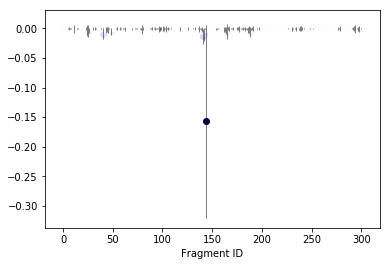

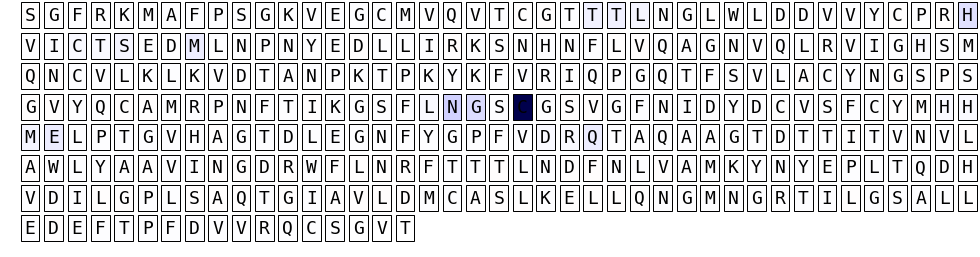

In [200]:
repop.represent(color_by='inhibitors')

('For n_clusters =', 2, 'The average silhouette_score is :', 0.12927024249674735)


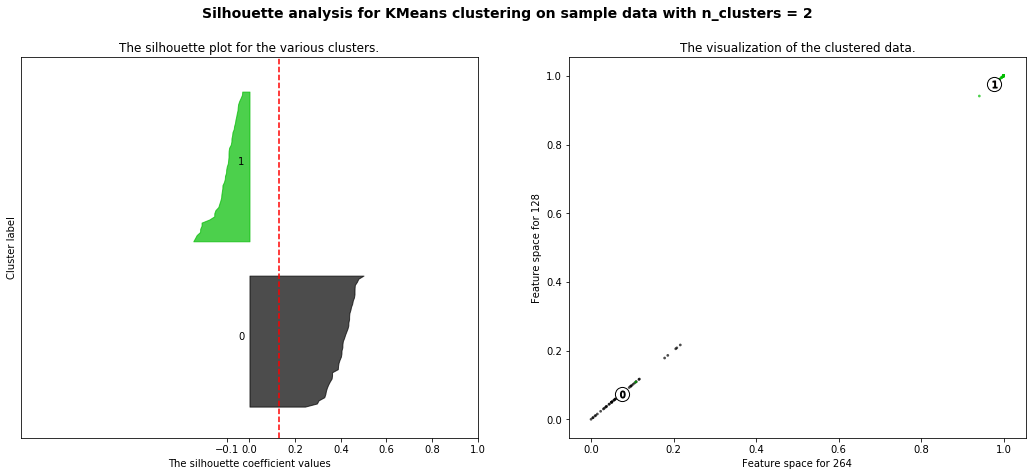

('For n_clusters =', 3, 'The average silhouette_score is :', 0.13158920384002715)


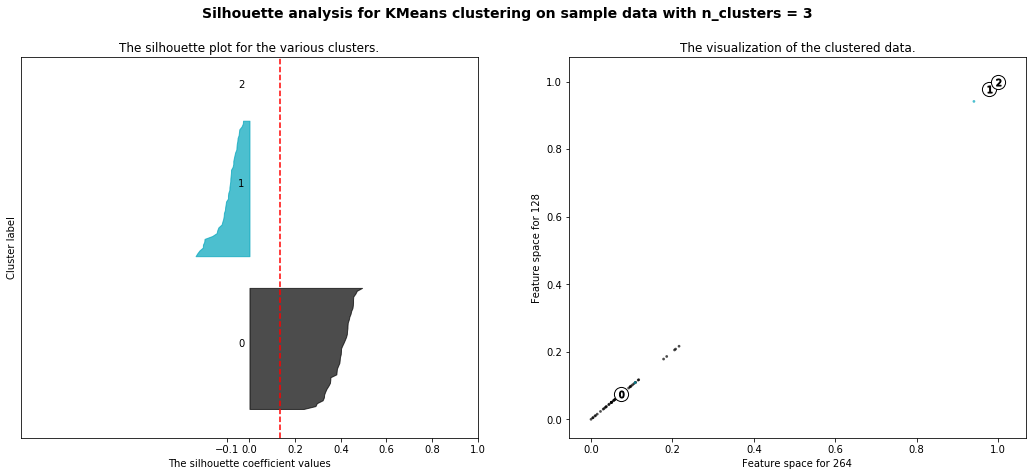

In [107]:
from BigDFT import Stats
reload(Stats)
from BigDFT.Stats import CData
clustering = CData(df2)
Sum_of_squared_distances = []
K = range(2,4)
for k in K:
    clustering.cluster_data(n_clusters=k)
    Sum_of_squared_distances.append(clustering.squared_distances)
    #ax = pop.plot_clusters(feature_two='A-CYS:145')
    plt = clustering.plot_cluster_info(feature_one=str(population.fragment_names.index('A-CYS:145')),
                                       feature_two=str(population.fragment_names.index('A-HIS:164')))
    if k >=2 :
        print("For n_clusters =", k,
              "The average silhouette_score is :", clustering.silhouette_avg)
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % k),
                     fontsize=14, fontweight='bold')
    plt.show()

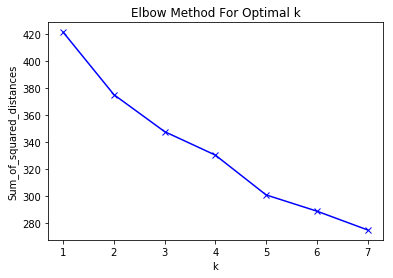

In [103]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [41]:
clustering.scaled_data[0][173]

0.9997482688330454

In [38]:
from numpy import isnan, where
where([[isnan(d) for dat in clustering.scaled_data  ]for d in dat])
    

(array([173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173,
        173, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,
        176, 176, 176, 176, 176, 176, 176, 176, 176

In [34]:
population.purities

{'A-ALA:116': -0.059577506842794115,
 'A-ALA:129': -0.05650334548441066,
 'A-ALA:173': -0.0585493247622456,
 'A-ALA:191': -0.05502843310618502,
 'A-ALA:193': -0.05341565877067544,
 'A-ALA:194': -0.053371914856251944,
 'A-ALA:206': -0.059384714361292536,
 'A-ALA:210': -0.05968511743291112,
 'A-ALA:211': -0.06122517385469209,
 'A-ALA:234': -0.0586553231281021,
 'A-ALA:255': -0.057015030791740806,
 'A-ALA:260': -0.05890266683234287,
 'A-ALA:266': -0.0599255065261234,
 'A-ALA:285': -0.056419815936729865,
 'A-ALA:7': -0.055215446764977937,
 'A-ALA:70': -0.05857953024761432,
 'A-ALA:94': -0.05573505593930414,
 'A-ARG:105': -0.0282037582743327,
 'A-ARG:131': -0.03161068248559393,
 'A-ARG:188': -0.03231940671272284,
 'A-ARG:217': -0.03036941535141364,
 'A-ARG:222': -0.03087313560437346,
 'A-ARG:279': -0.030657437924422205,
 'A-ARG:298': -0.031154895304121542,
 'A-ARG:4': -0.031856597041733145,
 'A-ARG:40': -0.029446290441177015,
 'A-ARG:60': -0.02823482504659139,
 'A-ARG:76': -0.02979940875701

In [12]:
tt = population.populations['interactions']

In [18]:
tt.cumsums[1]/tt.full_weight-tt.mean**2

,A-ALA:116,A-ALA:129,A-ALA:173,A-ALA:191,A-ALA:193,A-ALA:194,A-ALA:206,A-ALA:210,A-ALA:211,A-ALA:234,...,A-VAL:297,A-VAL:303,A-VAL:35,A-VAL:36,A-VAL:42,A-VAL:68,A-VAL:73,A-VAL:77,A-VAL:86,A-VAL:91
A-ALA:116,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.802597e-45,0.000000e+00
A-ALA:129,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.605194e-45,-6.681912e-52,0.000000e+00,...,0.000000e+00,2.802597e-45,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:173,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:191,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.232595e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:193,0.000000e+00,0.000000e+00,0.000000e+00,2.584939e-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:194,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:206,0.000000e+00,5.877472e-39,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.242078e-44,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:210,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.469368e-39,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:211,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.421085e-14,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:234,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [11]:
population.populations['interactions'].std

/home/genovese/binaries/1.9-py2/install/lib/python2.7/site-packages/BigDFT/Stats.py:110: RuntimeWarning: invalid value encountered in sqrt
  self.datas) > 1 else 0.0


,A-ALA:116,A-ALA:129,A-ALA:173,A-ALA:191,A-ALA:193,A-ALA:194,A-ALA:206,A-ALA:210,A-ALA:211,A-ALA:234,...,A-VAL:297,A-VAL:303,A-VAL:35,A-VAL:36,A-VAL:42,A-VAL:68,A-VAL:73,A-VAL:77,A-VAL:86,A-VAL:91
A-ALA:116,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
A-ALA:129,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00,...,0.000000e+00,5.293956e-23,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:173,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:191,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:193,0.000000e+00,0.000000e+00,0.0,1.607775e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:194,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:206,0.000000e+00,7.666467e-20,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,1.497357e-22,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:210,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:211,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A-ALA:234,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [25]:
for k,v in chessboards.items():
    frg = [v2 for f,vv in v.items() if 'A-CYS:145' in f for v2 in vv if 'LIG' not in v2]
    print k,len(v),len(frg), frg

0.045 163 5 [u'A-GLY:146', u'A-CYS:145', u'A-ASN:142', u'A-GLY:143', u'A-SER:144']
0.05 227 4 ['A-GLY:146', 'A-CYS:145', 'A-GLY:143', 'A-SER:144']
0.025 70 10 ['A-SER:139', 'A-PHE:140', 'A-SER:147', 'A-VAL:148', 'A-LEU:141', 'A-ASN:142', 'A-GLY:146', 'A-CYS:145', 'A-GLY:143', 'A-SER:144']
0.03 86 4 [u'A-SER:147', u'A-VAL:148', u'A-GLY:146', u'A-CYS:145']
0.035 112 6 [u'A-GLY:146', u'A-CYS:145', u'A-LEU:141', u'A-ASN:142', u'A-GLY:143', u'A-SER:144']
0.04 123 6 [u'A-GLY:146', u'A-CYS:145', u'A-LEU:141', u'A-ASN:142', u'A-GLY:143', u'A-SER:144']


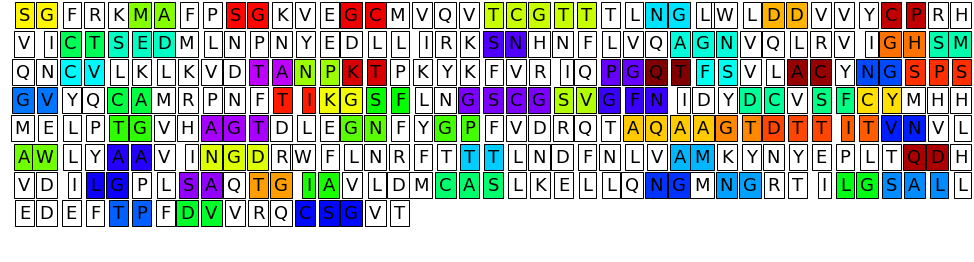

In [54]:
cd = population.refragmentation_colordict(chessboards[0.05])
population.display_sequences(colordict = cd)

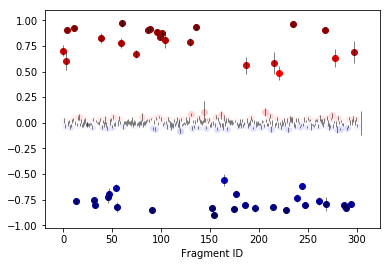

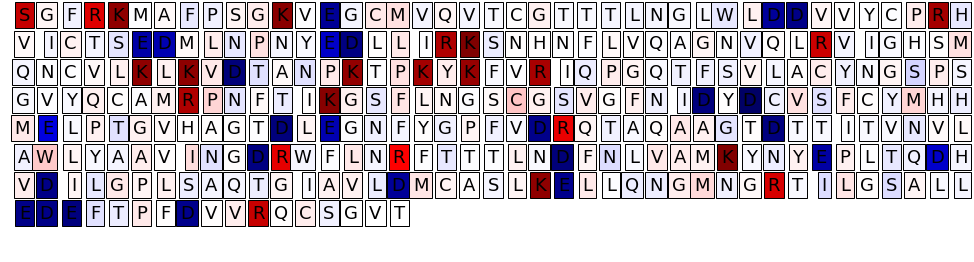

In [53]:
population.represent(color_by='charge')

In [45]:
view = {'A-LYS:88': ['A-LYS:88'], 'A-GLY:15+A-CYS:16': ['A-GLY:15', 'A-CYS:16'], 'A-LEU:67': ['A-LEU:67'], 'A-VAL:68+A-GLN:69': ['A-VAL:68', 'A-GLN:69'], 'A-THR:198+A-ASP:197': ['A-THR:198', 'A-ASP:197'], 'A-TYR:118': ['A-TYR:118'], 'A-MET:49': ['A-MET:49'], 'A-THR:111+A-GLN:110': ['A-THR:111', 'A-GLN:110'], 'A-SER:62+A-ASN:63': ['A-SER:62', 'A-ASN:63'], 'A-ASN:228+A-LEU:227': ['A-ASN:228', 'A-LEU:227'], 'A-ARG:298': ['A-ARG:298'], 'A-ILE:281': ['A-ILE:281'], 'A-SER:139+A-PHE:140': ['A-SER:139', 'A-PHE:140'], 'A-GLN:299': ['A-GLN:299'], u'A-VAL:303+A-CYS:300+A-GLY:302+A-SER:301': [u'A-VAL:303', u'A-CYS:300', u'A-GLY:302', u'A-SER:301'], 'A-ARG:217': ['A-ARG:217'], u'A-SER:123+A-SER:121+A-PRO:122': [u'A-SER:123', u'A-SER:121', u'A-PRO:122'], 'A-THR:292+A-PRO:293': ['A-THR:292', 'A-PRO:293'], u'A-VAL:204+A-ASN:203+A-THR:201+A-VAL:202': [u'A-VAL:204', u'A-ASN:203', u'A-THR:201', u'A-VAL:202'], 'A-MET:162': ['A-MET:162'], 'A-ALA:194+A-GLY:195+A-THR:196': ['A-ALA:194', 'A-GLY:195', 'A-THR:196'], 'A-ARG:60': ['A-ARG:60'], 'A-GLU:270': ['A-GLU:270'], 'A-LEU:75': ['A-LEU:75'], 'A-GLY:29+A-LEU:30': ['A-GLY:29', 'A-LEU:30'], 'A-TYR:209': ['A-TYR:209'], 'A-GLU:166+A-MET:165': ['A-GLU:166', 'A-MET:165'], 'A-ASN:238+A-TYR:237': ['A-ASN:238', 'A-TYR:237'], 'A-ARG:188': ['A-ARG:188'], 'A-ASN:180+A-PHE:181': ['A-ASN:180', 'A-PHE:181'], 'A-TYR:126': ['A-TYR:126'], 'A-SER:267+A-LEU:268': ['A-SER:267', 'A-LEU:268'], 'A-LEU:177': ['A-LEU:177'], 'A-LEU:242': ['A-LEU:242'], 'A-PRO:99+A-THR:98+A-LYS:97': ['A-PRO:99', 'A-THR:98', 'A-LYS:97'], 'A-ILE:259': ['A-ILE:259'], 'A-ILE:43': ['A-ILE:43'], 'A-ARG:105': ['A-ARG:105'], 'A-PHE:112': ['A-PHE:112'], 'A-SER:81+A-MET:82': ['A-SER:81', 'A-MET:82'], 'A-PRO:52+A-ASN:51': ['A-PRO:52', 'A-ASN:51'], 'A-GLU:288': ['A-GLU:288'], 'A-ARG:76': ['A-ARG:76'], 'A-VAL:212+A-ILE:213': ['A-VAL:212', 'A-ILE:213'], 'A-VAL:77+A-ILE:78': ['A-VAL:77', 'A-ILE:78'], 'A-MET:130': ['A-MET:130'], 'A-ILE:106': ['A-ILE:106'], 'A-LYS:269': ['A-LYS:269'], 'A-ASP:229+A-PHE:230': ['A-ASP:229', 'A-PHE:230'], 'A-TYR:239': ['A-TYR:239'], 'A-LEU:208': ['A-LEU:208'], 'A-MET:235': ['A-MET:235'], 'A-HIS:172': ['A-HIS:172'], 'A-ASN:84+A-CYS:85+A-VAL:86': ['A-ASN:84', 'A-CYS:85', 'A-VAL:86'], 'A-VAL:18+A-MET:17': ['A-VAL:18', 'A-MET:17'], 'A-PHE:66': ['A-PHE:66'], 'A-THR:25+A-THR:26': ['A-THR:25', 'A-THR:26'], 'A-PHE:223': ['A-PHE:223'], 'A-THR:280+A-ARG:279': ['A-THR:280', 'A-ARG:279'], 'A-ALA:193+A-GLN:192': ['A-ALA:193', 'A-GLN:192'], 'A-ASP:263+A-MET:264': ['A-ASP:263', 'A-MET:264'], 'A-PRO:132+A-ARG:131': ['A-PRO:132', 'A-ARG:131'], u'A-ASN:151+A-GLY:149+A-PHE:150': [u'A-ASN:151', u'A-GLY:149', u'A-PHE:150'], 'A-VAL:247+A-HIS:246': ['A-VAL:247', 'A-HIS:246'], 'A-GLN:127': ['A-GLN:127'], 'A-PRO:241+A-GLU:240': ['A-PRO:241', 'A-GLU:240'], 'A-ILE:59': ['A-ILE:59'], u'A-VAL:73+A-ALA:70+A-GLY:71+A-ASN:72': [u'A-VAL:73', u'A-ALA:70', u'A-GLY:71', u'A-ASN:72'], u'A-PRO:9+A-GLY:11+A-SER:10': [u'A-PRO:9', u'A-GLY:11', u'A-SER:10'], 'A-CYS:160+A-TYR:161': ['A-CYS:160', 'A-TYR:161'], 'A-VAL:297': ['A-VAL:297'], 'A-GLN:83': ['A-GLN:83'], 'A-GLN:256': ['A-GLN:256'], 'A-ALA:7+A-MET:6': ['A-ALA:7', 'A-MET:6'], 'A-HIS:164': ['A-HIS:164'], 'A-ARG:4': ['A-ARG:4'], 'A-HIS:163': ['A-HIS:163'], 'A-VAL:157+A-CYS:156+A-ASP:155': ['A-VAL:157', 'A-CYS:156', 'A-ASP:155'], 'A-ALA:206+A-TRP:207': ['A-ALA:206', 'A-TRP:207'], 'A-LEU:262': ['A-LEU:262'], u'A-ASP:92+A-ALA:94+A-THR:93': [u'A-ASP:92', u'A-ALA:94', u'A-THR:93'], 'A-LEU:141': ['A-LEU:141'], 'A-GLU:55+A-ASP:56+A-LEU:57': ['A-GLU:55', 'A-ASP:56', 'A-LEU:57'], 'A-GLY:183+A-PRO:184': ['A-GLY:183', 'A-PRO:184'], 'A-ASN:142+A-GLY:143+A-SER:144': ['A-ASN:142', 'A-GLY:143', 'A-SER:144'], 'A-THR:304': ['A-THR:304'], 'A-ALA:116+A-CYS:117': ['A-ALA:116', 'A-CYS:117'], 'A-GLU:14': ['A-GLU:14'], 'A-TRP:31': ['A-TRP:31'], 'A-ASP:153+A-ILE:152': ['A-ASP:153', 'A-ILE:152'], 'A-PRO:252+A-GLY:251+A-LEU:250': ['A-PRO:252', 'A-GLY:251', 'A-LEU:250'], 'A-VAL:91+A-LYS:90': ['A-VAL:91', 'A-LYS:90'], 'A-GLY:79+A-HIS:80': ['A-GLY:79', 'A-HIS:80'], u'A-THR:243+A-ASP:245+A-GLN:244': [u'A-THR:243', u'A-ASP:245', u'A-GLN:244'], 'A-GLY:179+A-GLU:178': ['A-GLY:179', 'A-GLU:178'], 'A-SER:147+A-VAL:148': ['A-SER:147', 'A-VAL:148'], 'A-PHE:291': ['A-PHE:291'], 'A-GLY:120+A-ASN:119': ['A-GLY:120', 'A-ASN:119'], 'A-LIG:306': ['A-LIG:306'], 'A-LIG:305': ['A-LIG:305'], 'A-LEU:271': ['A-LEU:271'], 'A-LEU:272': ['A-LEU:272'], 'A-GLY:278+A-ASN:277': ['A-GLY:278', 'A-ASN:277'], 'A-TYR:37': ['A-TYR:37'], 'A-GLN:74': ['A-GLN:74'], 'A-LEU:58': ['A-LEU:58'], 'A-LYS:100': ['A-LYS:100'], 'A-LYS:102': ['A-LYS:102'], 'A-LEU:50': ['A-LEU:50'], 'A-VAL:13+A-LYS:12': ['A-VAL:13', 'A-LYS:12'], 'A-THR:199+A-ILE:200': ['A-THR:199', 'A-ILE:200'], u'A-ASP:176+A-ALA:173+A-GLY:174+A-THR:175': [u'A-ASP:176', u'A-ALA:173', u'A-GLY:174', u'A-THR:175'], 'A-PHE:8': ['A-PHE:8'], 'A-ARG:40': ['A-ARG:40'], 'A-LEU:287': ['A-LEU:287'], 'A-GLN:273': ['A-GLN:273'], 'A-GLY:275+A-ASN:274': ['A-GLY:275', 'A-ASN:274'], 'A-ALA:234+A-VAL:233': ['A-ALA:234', 'A-VAL:233'], 'A-PRO:168+A-LEU:167': ['A-PRO:168', 'A-LEU:167'], 'A-ASP:289+A-GLU:290': ['A-ASP:289', 'A-GLU:290'], 'A-LEU:205': ['A-LEU:205'], 'A-GLY:109+A-PRO:108': ['A-GLY:109', 'A-PRO:108'], 'A-GLN:107': ['A-GLN:107'], 'A-GLY:283+A-LEU:282': ['A-GLY:283', 'A-LEU:282'], 'A-ALA:255+A-SER:254': ['A-ALA:255', 'A-SER:254'], 'A-ASN:231+A-LEU:232': ['A-ASN:231', 'A-LEU:232'], 'A-ASP:33+A-ASP:34': ['A-ASP:33', 'A-ASP:34'], 'A-VAL:104+A-PHE:103': ['A-VAL:104', 'A-PHE:103'], 'A-PHE:294': ['A-PHE:294'], 'A-LEU:89': ['A-LEU:89'], 'A-THR:224+A-THR:225+A-THR:226': ['A-THR:224', 'A-THR:225', 'A-THR:226'], u'A-ASP:48+A-SER:46+A-GLU:47': [u'A-ASP:48', u'A-SER:46', u'A-GLU:47'], 'A-LEU:115': ['A-LEU:115'], 'A-ASN:28+A-LEU:27': ['A-ASN:28', 'A-LEU:27'], 'A-MET:276': ['A-MET:276'], 'A-SER:158+A-PHE:159': ['A-SER:158', 'A-PHE:159'], 'A-LEU:87': ['A-LEU:87'], 'A-GLY:124+A-VAL:125': ['A-GLY:124', 'A-VAL:125'], u'A-VAL:20+A-THR:24+A-THR:21+A-GLY:23+A-CYS:22': [u'A-VAL:20', u'A-THR:24', u'A-THR:21', u'A-GLY:23', u'A-CYS:22'], 'A-TRP:218': ['A-TRP:218'], 'A-ALA:191+A-THR:190': ['A-ALA:191', 'A-THR:190'], 'A-ASP:216+A-GLY:215+A-ASN:214': ['A-ASP:216', 'A-GLY:215', 'A-ASN:214'], 'A-ASN:221+A-ARG:222': ['A-ASN:221', 'A-ARG:222'], 'A-PHE:185': ['A-PHE:185'], 'A-GLN:19': ['A-GLN:19'], 'A-LYS:61': ['A-LYS:61'], 'A-VAL:36+A-VAL:35': ['A-VAL:36', 'A-VAL:35'], 'A-GLY:258+A-THR:257': ['A-GLY:258', 'A-THR:257'], 'A-LYS:5': ['A-LYS:5'], 'A-ASN:53+A-TYR:54': ['A-ASN:53', 'A-TYR:54'], 'A-LEU:253': ['A-LEU:253'], 'A-ASP:295+A-VAL:296': ['A-ASP:295', 'A-VAL:296'], 'A-LEU:32': ['A-LEU:32'], 'A-GLY:138+A-LYS:137': ['A-GLY:138', 'A-LYS:137'], 'A-TYR:182': ['A-TYR:182'], 'A-VAL:186+A-ASP:187': ['A-VAL:186', 'A-ASP:187'], 'A-ASP:248+A-ILE:249': ['A-ASP:248', 'A-ILE:249'], 'A-SER:1+A-GLY:2+A-PHE:3': ['A-SER:1', 'A-GLY:2', 'A-PHE:3'], 'A-ALA:211+A-ALA:210': ['A-ALA:211', 'A-ALA:210'], 'A-LYS:236': ['A-LYS:236'], 'A-SER:284+A-ALA:285+A-LEU:286': ['A-SER:284', 'A-ALA:285', 'A-LEU:286'], 'A-ALA:129+A-CYS:128': ['A-ALA:129', 'A-CYS:128'], 'A-TYR:101': ['A-TYR:101'], 'A-CYS:38+A-PRO:39': ['A-CYS:38', 'A-PRO:39'], 'A-TYR:154': ['A-TYR:154'], 'A-LEU:220': ['A-LEU:220'], 'A-GLN:189': ['A-GLN:189'], 'A-SER:113+A-VAL:114': ['A-SER:113', 'A-VAL:114'], 'A-ALA:260+A-VAL:261': ['A-ALA:260', 'A-VAL:261'], 'A-THR:135+A-ILE:136': ['A-THR:135', 'A-ILE:136'], 'A-ASN:95+A-PRO:96': ['A-ASN:95', 'A-PRO:96'], 'A-ASN:65+A-HIS:64': ['A-ASN:65', 'A-HIS:64'], 'A-PHE:219': ['A-PHE:219'], 'A-GLY:146': ['A-GLY:146'], 'A-ASN:133+A-PHE:134': ['A-ASN:133', 'A-PHE:134'], 'A-VAL:171+A-GLY:170+A-THR:169': ['A-VAL:171', 'A-GLY:170', 'A-THR:169'], 'A-VAL:42+A-HIS:41': ['A-VAL:42', 'A-HIS:41'], 'A-ALA:266+A-CYS:265': ['A-ALA:266', 'A-CYS:265'], u'A-LIG:307+A-GLY:146+A-CYS:145': [u'A-GLY:146', u'A-CYS:145'], 'A-CYS:44+A-THR:45': ['A-CYS:44', 'A-THR:45']}

In [48]:
self=population
print {refrag: sum(self[f].q0[0] for f in remap) for refrag, remap in view.items()}

{'A-LYS:88': 0.9062412000000004, 'A-GLY:15+A-CYS:16': -0.027481699999998832, 'A-LEU:67': 0.0361838999999996, 'A-VAL:68+A-GLN:69': 0.015257599999998206, 'A-THR:198+A-ASP:197': -0.8697567000000003, 'A-TYR:118': -0.032139899999999, 'A-MET:49': 0.10448420000000025, 'A-THR:111+A-GLN:110': -0.06959379999999904, 'A-SER:62+A-ASN:63': -0.006997000000000808, 'A-ASN:228+A-LEU:227': 0.015201399999998588, 'A-THR:280+A-ARG:279': 0.6254108, 'A-ILE:281': -0.005959499999999451, 'A-SER:139+A-PHE:140': 0.04117020000000049, 'A-GLN:299': -0.03470170000000061, u'A-VAL:303+A-CYS:300+A-GLY:302+A-SER:301': -0.016366199999999775, 'A-ARG:217': 0.6303502000000011, u'A-SER:123+A-SER:121+A-PRO:122': -0.04278560000000042, 'A-THR:292+A-PRO:293': -0.017135499999999748, u'A-VAL:204+A-ASN:203+A-THR:201+A-VAL:202': -0.054436700000001115, 'A-MET:162': 0.0734643999999991, 'A-ALA:194+A-GLY:195+A-THR:196': -0.036237299999999695, 'A-ARG:60': 0.7867303999999993, 'A-GLU:270': -0.8841951000000009, 'A-LEU:75': 0.01210369999999982

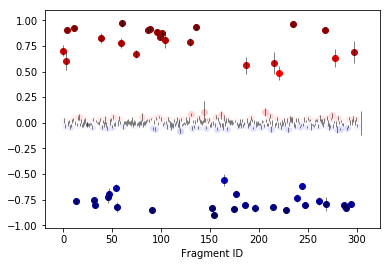

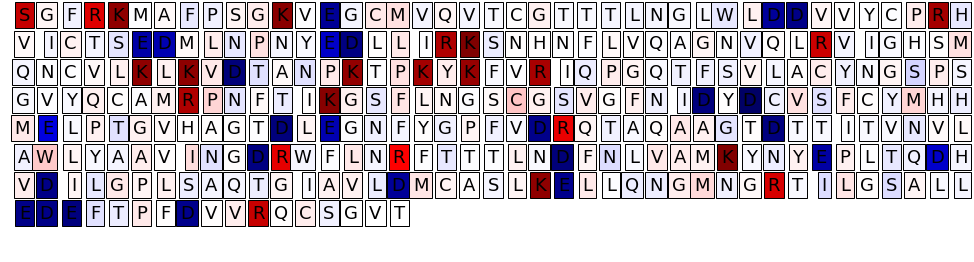

In [41]:
population.represent(color_by='charge')

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


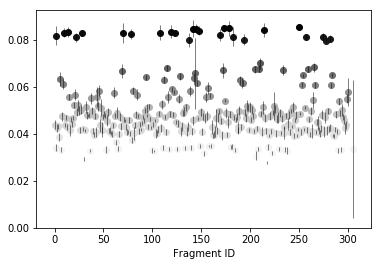

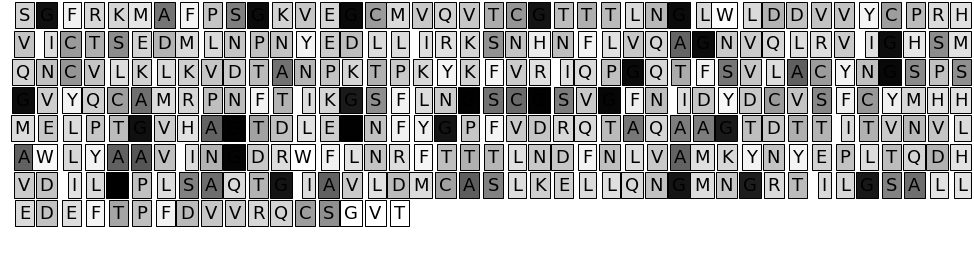

In [35]:
from numpy import min as mn, max as mx, mean
pvs = population.populations['purity'].datas
population.represent(field_vals=mean(pvs,axis=0),errors=0.5*(mx(pvs,axis=0)-mn(pvs,axis=0)),color_by='purity')

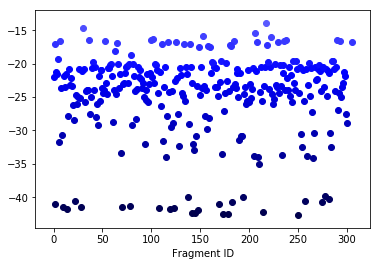

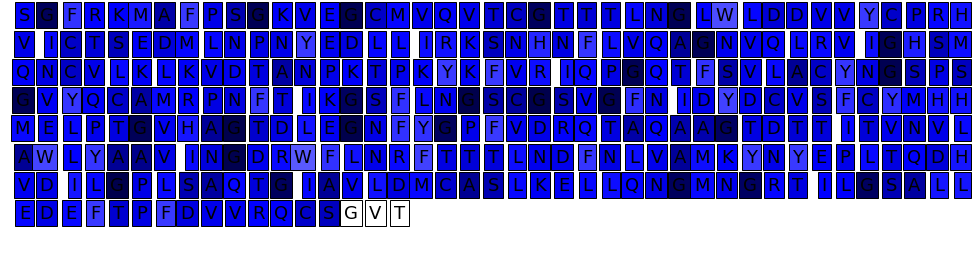

In [27]:
population.represent(field_vals=0.5*(maxa-mina))

In [45]:
import json
tt=json.load(open('/tmp/cached_refragment.json'))

In [58]:
posinp=tt['0.05'][0]['positions']
units=tt['0.05'][0]['units']

In [65]:
Systems.GetFragTuple('A-ALA:116')

('A', 'ALA:116')

In [66]:
from BigDFT import Systems
reload(Systems)
sys = Systems.system_from_dict_positions(posinp=posinp,units=units)

In [71]:
tt = population._cached_refragment['0.05']

In [72]:
tt[0]

In [73]:
population.refragment()

KeyError: 'positions'

In [15]:
def create_mapping(refrag):
    return {frag:frag.split('+') for frag in refrag}
        

In [30]:
newp,newbo = population.bigdft_tool.update_purity_and_bo(create_mapping(population.refragment(0.025)[0]),
                                            population.purities,population.bond_orders,
                                            {frag: f.qcharge for frag, f in population.items()})

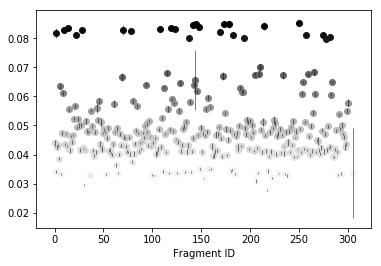

In [25]:
population.fragment_scatterplot(color_by='purity')


In [26]:
from matplotlib import pyplot as plt

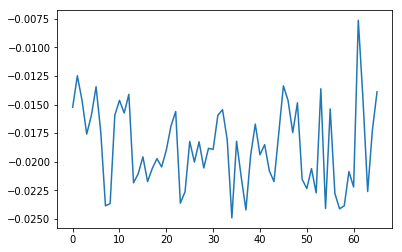

In [31]:
plt.plot(newp.values())

In [2]:
from pickle import load
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)

In [3]:
from multiprocessing import Pool
from pickle import load, dump
import time
from BigDFT import BioQM
from BigDFT.Systems import System
from os.path import join
from os.path import exists

# Read in the data
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)
    

# Fill in this routine with all of the loading you want to do
def read(geom):
    cname = join(cache, geom + ".pickle")

    try:
        with open(cname, "rb") as ifile:
            sys = load(ifile)
    except:
        fname = join(outdir, geom + "-XTB-1.1.tar.bz2")
        options = dict(sequence_from_fragments=True, disable_warnings=True)
        sys = BioQM.load(fname, options=options)
        energies = sys.interactions
        purities = sys.purities
        bond_orders = sys.bond_orders
        
        for attr in ["_atomic_purities", "_atomic_BO", "_atomic_interactions"]:
            if hasattr(sys, attr):
                delattr(sys, attr)
        
        with open(cname, "wb") as ofile:
            dump(sys, ofile)
        
    return geom, sys

# Set the number of threads yourself
numthreads = 3
p = Pool(numthreads)

# Actual call 
geoms = data["Crystal ID"][:]
systems = {}
start = time.time()
# res = p.map(read, geoms)
res = []
for g in geoms:
    print(g)
    res.append(read(g))
end = time.time()
print(end - start)

# Unpack results into this dictionary
for val in res:
    g = val[0]
    systems[g] = val[1]

Mpro-x0072
Mpro-x0104
Mpro-x0107
Mpro-x0161
Mpro-x0195
Mpro-x0305
Mpro-x0354
Mpro-x0387
Mpro-x0395
Mpro-x0397
Mpro-x0426
Mpro-x0434
Mpro-x0540
Mpro-x0678
Mpro-x0874
Mpro-x0946
Mpro-x0967
Mpro-x0991
Mpro-x0995
Mpro-x1077
Mpro-x1093
Mpro-x1249
Mpro-x0689
Mpro-x0691
Mpro-x0692
Mpro-x0705
Mpro-x0708
Mpro-x0731
Mpro-x0734
Mpro-x0736
Mpro-x0749
Mpro-x0752
Mpro-x0755
Mpro-x0759
Mpro-x0769
Mpro-x0770
Mpro-x0771
Mpro-x0774
Mpro-x0786
Mpro-x0820
Mpro-x0830
Mpro-x0831
Mpro-x0978
Mpro-x0981
Mpro-x1308
Mpro-x1311
Mpro-x1334
Mpro-x1336
Mpro-x1348
Mpro-x1351
Mpro-x1358
Mpro-x1374
Mpro-x1375
Mpro-x1380
Mpro-x1382
Mpro-x1384
Mpro-x1385
Mpro-x1386
Mpro-x1392
Mpro-x1402
Mpro-x1412
Mpro-x1418
Mpro-x1425
Mpro-x1458
Mpro-x1478
Mpro-x1493
Mpro-x0887
Mpro-x1187
Mpro-x1012
Mpro-x0390
Mpro-x0464
Mpro-x0425
Mpro-x0398
Mpro-x0669
Mpro-x1163
Mpro-x0478
Mpro-x0177
Mpro-x0194
Mpro-x1226
Mpro-x1235
Mpro-x0350
Mpro-x1002
Mpro-x1132
Mpro-x1237
Mpro-x0499
Mpro-x1119
Mpro-x0376
Mpro-x0165
Mpro-x0336
Mpro-x1086
Mpro-x1101

First, let's analyze this data so we can understand the broad trends in variance in purity across samples.

In [4]:
from BigDFT.Systems import GetFragTuple

mindict = {}
maxlookup = {}
maxdict = {}
avgdict = {}
count = {}

for g in geoms:
    for fragid, pv in systems[g].purities.items():
        pv = abs(pv)
        if "LIG" in fragid or "FRA" in fragid:
            continue
            
        if fragid not in mindict:
            mindict[fragid] = pv
        elif mindict[fragid] > pv:
            mindict[fragid] = pv
        
        if fragid not in maxdict:
            maxdict[fragid] = pv
            maxlookup[fragid] = g
        elif maxdict[fragid] < pv:
            maxdict[fragid] = pv
            maxlookup[fragid] = g
            
        if fragid not in avgdict:
            avgdict[fragid] = pv
            count[fragid] = 1
        else:
            avgdict[fragid] += pv
            count[fragid] += 1
            
for fragid in avgdict:
    avgdict[fragid] /= count[fragid]
    
deviation = {}
for fragid in mindict:
    deviation[fragid] = abs(mindict[fragid] - maxdict[fragid])

order = sorted(mindict, key=avgdict.get)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


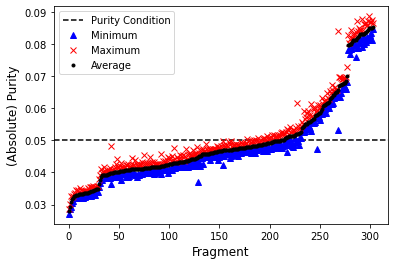

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.axhline(0.05, color='k', linestyle='--', label="Purity Condition")
axs.plot([mindict[x] for x in order], 'b^', label="Minimum")
axs.plot([maxdict[x] for x in order], 'rx', label="Maximum")
axs.plot([avgdict[x] for x in order], 'k.', label="Average")
axs.set_xlabel("Fragment", fontsize=12)
axs.set_ylabel("(Absolute) Purity", fontsize=12)
axs.legend()
plt.savefig(join("pictures", "pdeviation.eps"))

In [6]:
distribution = {x: maxdict[x] - mindict[x] for x in maxdict}
for fragid in sorted(distribution, key=distribution.get, reverse=True):
    if abs(distribution[fragid]) > 0.005:
        print(fragid, distribution[fragid], maxlookup[fragid])

A-CYS:145 0.030615910129419152 Mpro-x1308
A-SER:301 0.012200494707174617 Mpro-x0434
A-THR:225 0.011972412663658706 Mpro-x1336
A-THR:304 0.011893814404302025 Mpro-x0195
A-VAL:303 0.008735230075572725 Mpro-x1478
A-GLY:71 0.008610979501187638 Mpro-x0387
A-CYS:44 0.00853170665945139 Mpro-x1334
A-GLY:2 0.008355049163353667 Mpro-x0177
A-GLY:183 0.007986584399953103 Mpro-x1235
A-GLU:166 0.0075586504088058296 Mpro-x1093
A-ASP:48 0.007251169942995878 Mpro-x0731
A-GLY:143 0.007217826673383401 Mpro-x0387
A-CYS:265 0.0066226931321647226 Mpro-x0669
A-ALA:173 0.006281809023401988 Mpro-x1101-1
A-GLY:109 0.00623623038297029 Mpro-x0376
A-ALA:70 0.0062319516997089985 Mpro-x0464
A-GLY:179 0.0062011308465882015 Mpro-x1101-0
A-MET:49 0.006137185984243156 Mpro-x1351
A-MET:162 0.00596992378003975 Mpro-x0736
A-ALA:7 0.005947849247161442 Mpro-x1132
A-GLY:138 0.005889023842875291 Mpro-x0887
A-GLU:270 0.0058817560171604485 Mpro-x1493
A-GLY:215 0.005879462232056848 Mpro-x0734
A-GLY:120 0.005794907097163349 Mpro-x

Now we can move to auto fragmentation.

In [7]:
from BigDFT.PostProcessing import BigDFTool
btool = BigDFTool()

In [8]:
def get_target(purities):
    mindict = {}
    for g in purities:
        mindict[g] = min(purities[g].values())
    target = min(mindict, key=mindict.get)
    return target, min(purities[target].values())

In [9]:
tail = ["A-GLY:302", "A-VAL:303", "A-THR:304"]

In [10]:
from copy import deepcopy
from BigDFT.Systems import System

resys = {}
purities = {}
bond_orders = {}

for g in data["Crystal ID"][:]:
    resys[g] = System(systems[g])
    purities[g] = deepcopy(systems[g].purities)
    bond_orders[g] = deepcopy(systems[g].bond_orders)

    # Remove the ligands
    fraglist = deepcopy(list(resys[g].keys()))
    for fragid in fraglist:
        if "FRA" in fragid or "LIG" in fragid or  fragid in tail:
            del resys[g][fragid]
            del purities[g][fragid]
            del bond_orders[g][fragid]
    
    for f1 in bond_orders[g]:
        fraglist = deepcopy(list(bond_orders[g][f1]))
        for f2 in fraglist:
            if "FRA" in f2 or "LIG" in f2 or f2 in tail:
                del bond_orders[g][f1][f2]

In [11]:
target, minval = get_target(purities)

In [12]:
charges = {x: sum([z.nel for z in y]) for x, y in resys[target].items()}

In [ ]:
from BigDFT.Fragments import Fragment

target, minval = get_target(purities)

while (abs(minval) > 0.05):
    print("Current worst purity value", minval, target)
    fw = FragmentView(resys[target]) # from BioSystems
    mapping = resys[target].refragment(fw,0.05)
          
    # Update the other systems
    for g in data["Crystal ID"][:]:
        fw_g = FragmentView(resys[g])
        fw_g_new = fw.refragment(mapping)
        
        resys[g] = impose_view(fw_g_new)
    
    target, minval = get_target(purities)

In [13]:
from BigDFT.Fragments import Fragment

target, minval = get_target(purities)

while (abs(minval) > 0.05):
    print("Current worst purity value", minval, target)
    autofrag = btool.auto_fragment(resys[target], purities[target], bond_orders[target], 0.05)
    
    # Create the mapping
    mapping = {}
    for fragid in autofrag:
        mapping[fragid.replace("+","#")] = [x for x in fragid.split("+")]
        
    # Update the other systems
    for g in data["Crystal ID"][:]:
        charges = {x: sum([z.nel for z in y]) for x, y in resys[g].items()}
        new_pv, new_bo = btool.update_purity_and_bo(mapping, purities[g], bond_orders[g], charges)

        new_sys = System()
        for f1, fraglist in mapping.items():
            new_sys[f1] = Fragment()
            for f2 in fraglist:
                new_sys[f1] += resys[g][f2]

        resys[g] = new_sys
        purities[g] = new_pv
        bond_orders[g] = new_bo
    
    target, minval = get_target(purities)

Current worst purity value -0.08858190720233974 Mpro-x0387
Current worst purity value -0.05353204603556079 Mpro-x0731
Current worst purity value -0.05227877682142599 Mpro-x1374
Current worst purity value -0.051511988386888745 Mpro-x0395
Current worst purity value -0.051411330738778384 Mpro-x0354
Current worst purity value -0.05105204697579718 Mpro-x1163
Current worst purity value -0.050680411008359266 Mpro-x0752
Current worst purity value -0.05055960191492771 Mpro-x0540
Current worst purity value -0.05055134169467742 Mpro-x0831
Current worst purity value -0.05032820945976135 Mpro-x1101-1
Current worst purity value -0.050090332177578904 Mpro-x0769
Current worst purity value -0.050069299668078486 Mpro-x1119


In [14]:
mindict = {}
maxdict = {}
maxlookup = {}
avgdict = {}
count = {}

for sys in data["Crystal ID"][:]:
    for fragid, pv in purities[sys].items():
        pv = abs(pv)
        if fragid not in mindict:
            mindict[fragid] = pv
        elif mindict[fragid] > pv:
            mindict[fragid] = pv
        
        if fragid not in maxdict:
            maxdict[fragid] = pv
            maxlookup[fragid] = sys
        elif maxdict[fragid] < pv:
            maxdict[fragid] = pv
            maxlookup[fragid] = sys
            
        if fragid not in avgdict:
            avgdict[fragid] = pv
            count[fragid] = 1
        else:
            avgdict[fragid] += pv
            count[fragid] += 1
            
for fragid in avgdict:
    avgdict[fragid] /= count[fragid]
    
deviation = {}
for fragid in mindict:
    deviation[fragid] = abs(mindict[fragid] - maxdict[fragid])

order = sorted(mindict, key=avgdict.get)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


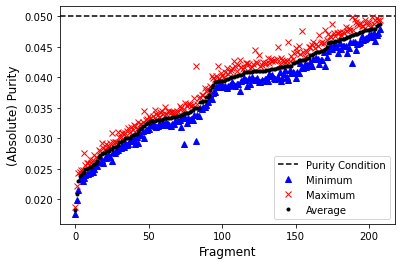

In [15]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.axhline(0.05, color='k', linestyle='--', label="Purity Condition")
axs.plot([mindict[x] for x in order], 'b^', label="Minimum")
axs.plot([maxdict[x] for x in order], 'rx', label="Maximum")
axs.plot([avgdict[x] for x in order], 'k.', label="Average")
axs.set_xlabel("Fragment", fontsize=12)
axs.set_ylabel("(Absolute) Purity", fontsize=12)
axs.legend()
plt.savefig(join("pictures", "pdeviation.eps"))

In [16]:
distribution = {x: maxdict[x] - mindict[x] for x in maxdict}
for fragid, d in distribution.items():
    if abs(d) > 0.005:
        print(fragid, d, maxlookup[fragid])

A-MET:49 0.006137185984243149 Mpro-x1351
A-CYS:145#A-GLY:143#A-SER:144 0.012294142449482355 Mpro-x1308
A-MET:162 0.00596992378003975 Mpro-x0736
A-GLU:166 0.007558650408805823 Mpro-x1093
A-MET:235 0.005016914927846235 Mpro-x0991
A-GLU:270 0.0058817560171604485 Mpro-x1493
A-SER:301#A-CYS:300 0.005719487512443718 Mpro-x0195


In [17]:
biosys = BioQM.load(join(outdir, data["Crystal ID"][0] + "-XTB-1.1.tar.bz2"),
                    options=dict(sequence_from_fragments=True, disable_warnings=True))

In [18]:
colorlist = []
# for f1 in biosys.fragment_names:
for f1 in biosys.keys():
    for f2 in purities[data["Crystal ID"][0] ]:
        if f1 in f2:
            colorlist.append(distribution[f2])
            break

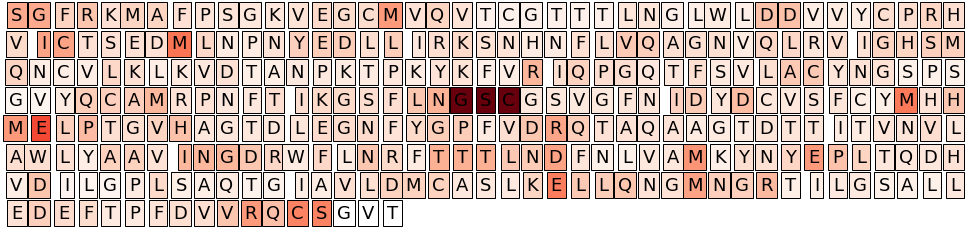

In [19]:
biosys.display_sequences(field_vals=colorlist)

## Strongest Interactors
Now we try to investigate the strongest interacting fragments. 

In [20]:
strengths = {}
full_strengths = {}
for g in geoms:
    full_strengths[g] = 0.0
    for fid1, f1 in systems[g].interactions.items():
        if "FRA" not in fid1 and "LIG" not in fid1:
            continue
        temp = 0.0
        for fid2, f2 in f1.items():
            if "FRA" in fid2 or "LIG" in fid2:
                continue
            temp += f2
        if abs(temp) > 0.05:
            strengths[(g,fid1)] = temp
        full_strengths[g] += temp

First summarize the total interaction strength.

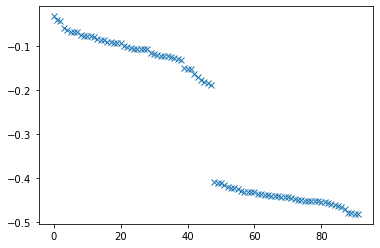

In [21]:
fig, axs = plt.subplots(1,1)
axs.plot(sorted(full_strengths.values(), reverse=True), 'x')

Text(0, 0.5, 'Interaction Strength')

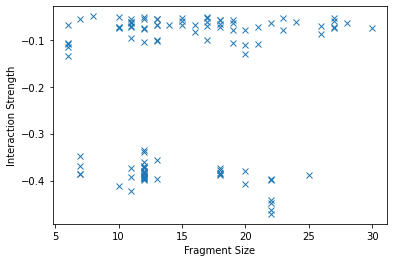

In [22]:
fig, axs = plt.subplots(1,1)
sizes = [len(systems[x[0]][x[1]]) for x in strengths]
values = list(strengths.values())

axs.plot(sizes, values, 'x')
axs.set_xlabel("Fragment Size")
axs.set_ylabel("Interaction Strength")

In [23]:
from os import system
from BigDFT.IO import write_pdb

smiles = {}
for g, f1 in strengths:
    name = str(g) + "-" + f1
    oname1 = join(cache, name+"-strongest.pdb")
    oname2 = join(cache, name+"-strongest.smiles")
    
    sys = System()
    sys[f1] = systems[g][f1]
    
    with open(oname1, "w") as ofile:
        write_pdb(sys, ofile)
    
    system("obabel -ipdb " + oname1 + " -ocan > " + oname2)
    
    with open(oname2) as ifile:
        smiles[(g, f1)] = next(ifile).split()[0]

In [24]:
covalent_lookup = {}
for g, c in zip(data["Crystal ID"], data["Site"]):
    covalent_lookup[g] = "cov" in c

for g, f1 in sorted(strengths, key=strengths.get, reverse=False):
#     if covalent_lookup[g]:
        print(g, f1, smiles[(g,f1)], strengths[(g,f1)], covalent_lookup[g])

Mpro-x0731 A-LIG:305 OS(N1CCN(CC1)C(=O)C)O -0.4708739555849365 True
Mpro-x0691 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.4618692302722154 True
Mpro-x0769 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.4483691139121299 True
Mpro-x1336 A-LIG:305 OS(N1CCN(CC1)C(=O)C)O -0.4407767246297145 True
Mpro-x0708 A-LIG:305 O=CNNC(=O)C -0.4213614961974834 True
Mpro-x0752 A-LIG:306 CNC(=O)C -0.4116628527137513 True
Mpro-x1375 A-LIG:305 CC(=O)N[C@@H]1CCS(=O)(=O)C1 -0.4069038124852839 True
Mpro-x0771 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.3984779041577044 True
Mpro-x1493 A-LIG:306 CC(=O)N(C)C -0.39843686349287677 True
Mpro-x0820 A-LIG:306 CCNC(=O)C -0.3961975698172323 True
Mpro-x0734 A-LIG:307 CC(=O)N(C)C -0.39578959220995047 True
Mpro-x1418 A-LIG:306 CN1CCN(CC1)C(=O)C -0.3954829304365555 True
Mpro-x0759 A-LIG:305 CC(=O)N(C)C -0.3945419570436842 True
Mpro-x0755 A-LIG:307 CC(=O)N(C)C -0.39376456768415613 True
Mpro-x0692 A-LIG:306 CC(=O)N(C)C -0.39334362460409944 True
Mpro-x0689 A-LIG:305 CC(=O)N(C)C -0.39209056672473747 True
